In [35]:
%matplotlib inline


Autograd: Automatic Differentiation
===================================

Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.


The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

Let us see this in more simple terms with some examples.

Tensor
--------

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with
``requires_grad=True``, but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.



In [36]:
import torch

Create a tensor and set ``requires_grad=True`` to track computation with it



In [37]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Do a tensor operation:



In [38]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.



In [39]:
print(y.grad_fn)

Do more operations on ``y``



In [40]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward>) tensor(27., grad_fn=<MeanBackward1>)


``.requires_grad_( ... )`` changes an existing Tensor's ``requires_grad``
flag in-place. The input flag defaults to ``False`` if not given.



In [41]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


In [42]:
print(z)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward>)


Gradients
---------
Let's backprop now.
Because ``out`` contains a single scalar, ``out.backward()`` is
equivalent to ``out.backward(torch.tensor(1.))``.



In [43]:
out.backward()

Print gradients d(out)/dx




In [44]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You should have got a matrix of ``4.5``. Let’s call the ``out``
*Tensor* “$o$”.
We have that $o = \frac{1}{4}\sum_i z_i$,
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.
Therefore,
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.



Mathematically, if you have a vector valued function $\vec{y}=f(\vec{x})$,
then the gradient of $\vec{y}$ with respect to $\vec{x}$
is a Jacobian matrix:

\begin{align}J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\end{align}

Generally speaking, ``torch.autograd`` is an engine for computing
vector-Jacobian product. That is, given any vector
$v=\left(\begin{array}{cccc} v_{1} & v_{2} & \cdots & v_{m}\end{array}\right)^{T}$,
compute the product $v^{T}\cdot J$. If $v$ happens to be
the gradient of a scalar function $l=g\left(\vec{y}\right)$,
that is,
$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$,
then by the chain rule, the vector-Jacobian product would be the
gradient of $l$ with respect to $\vec{x}$:

\begin{align}J^{T}\cdot v=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\left(\begin{array}{c}
   \frac{\partial l}{\partial y_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial y_{m}}
   \end{array}\right)=\left(\begin{array}{c}
   \frac{\partial l}{\partial x_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial x_{n}}
   \end{array}\right)\end{align}

(Note that $v^{T}\cdot J$ gives a row vector which can be
treated as a column vector by taking $J^{T}\cdot v$.)

This characteristic of vector-Jacobian product makes it very
convenient to feed external gradients into a model that has
non-scalar output.



Now let's take a look at an example of vector-Jacobian product:



In [45]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([1133.0045, -269.0696,  272.1798], grad_fn=<MulBackward>)


Now in this case ``y`` is no longer a scalar. ``torch.autograd``
could not compute the full Jacobian directly, but if we just
want the vector-Jacobian product, simply pass the vector to
``backward`` as argument:



In [46]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([ 51.2000, 512.0000,   0.0512])


In [47]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([-947.4844,  609.7604, 1100.4192], grad_fn=<MulBackward>)
tensor([ 102.4000, 1024.0000,    0.1024])


You can also stop autograd from tracking history on Tensors
with ``.requires_grad=True`` by wrapping the code block in
``with torch.no_grad():``



In [48]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
	print((x ** 2).requires_grad)

True
True
False


**Read Later:**

Documentation of ``autograd`` and ``Function`` is at
https://pytorch.org/docs/autograd



In [88]:
import torch.nn as nn
m = nn.Linear(5, 8)
input = torch.randn(5, 5)
print(input.is_leaf)
output = m(input)
print(output.is_leaf)

True
False


In [86]:
# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
y = torch.tensor(2.0)
z = x * y

# Displaying
for i, name in zip([x, y, z], "xyz"):
    print(f"{name}\ndata: {i.data}\nrequires_grad: {i.requires_grad}\n\
grad: {i.grad}\ngrad_fn: {i.grad_fn}\nis_leaf: {i.is_leaf}\n")

x
data: 1.0
requires_grad: True
grad: None
grad_fn: None
is_leaf: True

y
data: 2.0
requires_grad: False
grad: None
grad_fn: None
is_leaf: True

z
data: 2.0
requires_grad: True
grad: None
grad_fn: <ThMulBackward object at 0x000002135510CB00>
is_leaf: False



In [91]:
# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
z = x ** 3
z.backward() #Computes the gradient 
print(x.grad) #Prints '3' which is dz/dx 

tensor(3.)


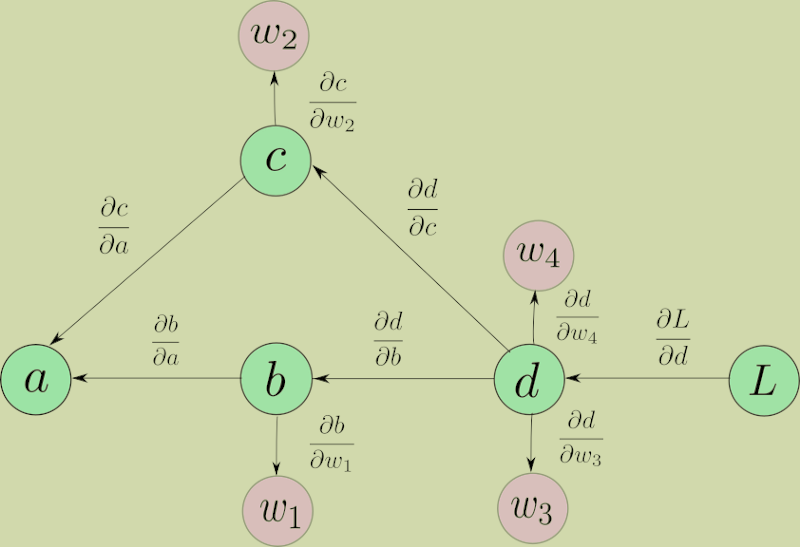

In [114]:
from torch import FloatTensor
from torch.autograd import Variable


# Define the leaf nodes
a = Variable(FloatTensor([4]))

weights = [Variable(FloatTensor([i]), requires_grad=True) for i in (2, 5, 9, 7)]

# unpack the weights for nicer assignment
w1, w2, w3, w4 = weights

b = w1 * a
c = w2 * a
d = w3 * b + w4 * c
L = (10 - d)

L.backward()

for index, weight in enumerate(weights, start=1):
    gradient, *_ = weight.grad
    print(f"Gradient of w{index} w.r.t to L: {gradient}")

Gradient of w1 w.r.t to L: -36.0
Gradient of w2 w.r.t to L: -28.0
Gradient of w3 w.r.t to L: -8.0
Gradient of w4 w.r.t to L: -20.0
